### Produce Maps

In [7]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt

import socket
import os as os
import sys as sys
import multiprocessing as mp
import matplotlib.cm as cm
import matplotlib.colors as cls
import matplotlib.colorbar as clb
from matplotlib import gridspec

# For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
# Make sure to have the font installed (it is on cluster for Harald)
rcParams['font.sans-serif'] = ['Arial']

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/punic_aDNA/"  # The Path on HMS Cluster
else:
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")
print(sys.version)

import mpl_toolkits
mpl_toolkits.__path__.append('/n/groups/reich/hringbauer/explore_ntbk/jptvenv37/lib/python3.7/site-packages/basemap-1.2.1-py3.7-linux-x86_64.egg/mpl_toolkits/')
from mpl_toolkits.basemap import Basemap

compute-e-16-229.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/punic_aDNA
CPU Count: 28
3.7.4 (default, Sep 11 2019, 11:24:51) 
[GCC 6.2.0]


# Helper Function

In [14]:
def remove_individuals(df, remove_list=["_d"], iid_col="iid"):
    """Remove indivdiuals from PCA dataframe"""
    idx = df[iid_col].str.contains("|".join(remove_list))
    df = df[~idx].copy()
    print(f"Filtering to {len(df)}/{len(idx)}")
    return df

def get_sub_iid(df, pops=[""], iid_col="iid"):
    """Remove indivdiuals from PCA dataframe"""
    idx = df[iid_col].str.contains("|".join(pops))
    df = df[idx].copy()
    print(f"Found: {len(df)}/{len(idx)}")
    return df

def get_sub_pops(df, pop_list=[], pop_col="pop"):
    """Get Sub Populations"""
    idx = df[pop_col].str.contains("|".join(pop_list))
    df = df[idx].copy()
    print(f"Found: {len(df)}/{len(idx)}")
    return df

def get_sub_pops_exact(df, pop_list=[], pop_col="pop"):
    """Get Sub Populations"""
    idx = df[pop_col].isin(pop_list)
    df = df[idx].copy()
    print(f"Found: {len(df)}/{len(idx)}")
    return df

# Get the Data

In [15]:
min_snp = 30000
path_pca = "./output/pca/v49.2/20210809.punic.v49.2_HO.construct_WE_NA_PCA.smYES.outitY.evec.txt"
df = pd.read_csv(path_pca, 
                 sep=r"\s+", skiprows=1, header=None)
df.columns=["iid", "pc1", "pc2", "pc3", "pc4", "pop"]
df = remove_individuals(df, remove_list=["_d"])

df_meta = pd.read_csv("/n/groups/reich/hringbauer/Data/v51.1.anno.csv", sep=",")
df2 = df_meta[["iid", "Master ID", "loc", "n_cov_snp", "avg_cov_snp", "sex", "age"]]
df = pd.merge(df, df2, on="iid", how="left")
idx = (df["n_cov_snp"]<min_snp)
df = df[~idx]
df.loc[df["loc"].isnull(), "loc"]="not assigned"
print(f"Filtered to {len(df)} Individuals based on Min SNP: {min_snp}")

df = df.sort_values(by="n_cov_snp", ascending=False)
dup = (df["Master ID"].duplicated() & ~df["Master ID"].isnull())
df = df[~dup].copy().reset_index(drop=True)
print(f"Filtered to {len(df)} based on duplicates")

Filtering to 2209/2209
Filtered to 2164 Individuals based on Min SNP: 30000
Filtered to 2099 based on duplicates


In [4]:
df_sard = get_sub_pops(df, pop_list=["Italy_Sardinia_Punic"])

Found: 18/2095


# Do the Timeline Plot

In [13]:
def plot_timeline(df, fs = 10, c = "royalblue", marker="o", plot_col="avg_cov_snp",
                  xlim=[0,700], ylim=[1e-2, 1.25e1], ylabel="Mean Coverage on 1240K SNPs",
                  x_ticks = [0.1, 1,10], s=70, savepath="", invert_age=True):
    """Plot timeline of samples"""
    
    ### Transform to calBCE
    x, y = df["age"].values-1950, df[plot_col].values.astype("float")
    txts = df["iid"].values
    
    plt.figure(figsize=(8,3))
    ax = plt.gca()
    
    unique_markers = set(marker)  # or yo can use: np.unique(m)
    for um in unique_markers:
        mask = marker == um 
        ax.scatter(x[mask], y[mask], edgecolors="k", marker=um, 
                   c=c[mask], s=s)
    
    if len(ylim)>0:
        ax.set_ylim(ylim)
    if len(xlim)>0:
        ax.set_xlim(xlim)
    ax.set_ylabel(ylabel, fontsize=fs)
    ax.set_xlabel("Age [years BCE]", fontsize=fs)
    ax.set_yscale("log")

    for i, txt in enumerate(txts):
        plt.text(x[i], y[i]*1.25, txt, fontsize=9, clip_on=True)

    ### Horizontal Lines:

    for x in x_ticks:
        ax.axhline(x, color="gray", linestyle="dashed", linewidth=0.5, zorder=0)

    ax.axhline(0.024, color="red", linestyle="-", linewidth=0.5, zorder=0)  
        
    if invert_age:
        ax.invert_xaxis()     
        
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
        print(f"Saved to {savepath}")
        
    plt.show()

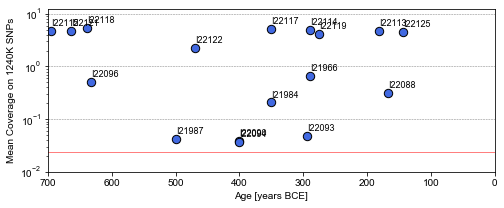

In [15]:
plot_timeline(df_sard, savepath="", invert_age=True) # ./figures/timeline/timeline_sard.pdf

Found: 29/1770
Saved to ./figures/timeline/timeline_kerk.pdf


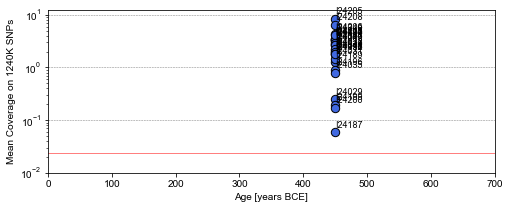

In [13]:
df_kerk = get_sub_pops(df, pop_list=["Tunisia_Punic"])
plot_timeline(df_kerk, savepath="./figures/timeline/timeline_kerk.pdf")

In [38]:
np.sum(df_kerk["avg_cov_snp"].astype("float")>2.5)

14

In [24]:
len(df_kerk)

29

### Villaricos

Found: 13/1770
Saved to ./figures/timeline/timeline_vill.pdf


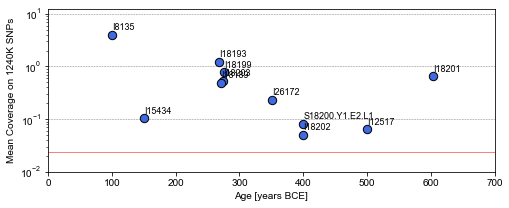

In [22]:
df_ib = get_sub_pops(df, pop_list=["Spain_Punic"])
plot_timeline(df_ib, savepath="./figures/timeline/timeline_vill.pdf")

# Plot Timeline for North African Samples

In [98]:
df_alg = get_sub_pops(df, pop_list=["Algeria"])

Found: 2/2099


In [99]:
df_alg

,iid,pc1,pc2,pc3,pc4,pop,Master ID,loc,n_cov_snp,avg_cov_snp,sex,age
211,I12433,-0.046233,-0.053706,-0.051445,-0.050176,Algeria_IA,I12433,"Aurès, Constantine, Khenchela Cave",756415.0,4.103941,F,2752.0
348,I11896,-0.061789,-0.053084,-0.093039,-0.081204,Algeria_N,I11896,Meskiana,615277.0,1.005341,F,6550.0


In [33]:
df_tun = get_sub_pops(df, pop_list=["Tunisia_Mesolithic|Tunisia_N|Tunisia_EN|Tunisia_LN"])
#df_tun = get_sub_pops(df, pop_list=["Tunisia"])
#plot_timeline(df_ib, savepath="./figures/timeline/timeline_vill.pdf")

Found: 8/2099


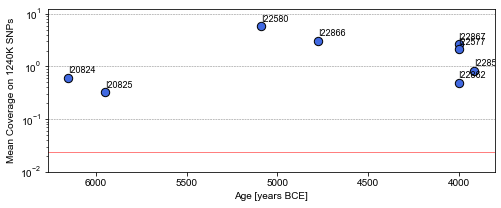

In [39]:
plot_timeline(df_tun, savepath="", xlim=[])

In [ ]:
color_dct = {"Djebba":"red", "Doukanet el Khoutifa":"blue", "Hergla":"green"}

# Timeline for new Morocco Sample

In [16]:
df_mor = get_sub_pops(df, pop_list=["Morocco_EN|Morocco_Iberomaurusian|Morocco_LN"])

Found: 13/2099


In [17]:
df_mor.sort_values(by="age", ascending=False)

,iid,pc1,pc2,pc3,pc4,pop,Master ID,loc,n_cov_snp,avg_cov_snp,sex,age
234,TAF010,-0.075535,-0.071517,-0.099871,-0.104475,Morocco_Iberomaurusian,TAF010,Taforalt,742144.0,3.060592,M,14649.0
69,TAF013,-0.076437,-0.070282,-0.102683,-0.097554,Morocco_Iberomaurusian,TAF013,Taforalt,922415.0,7.166829,M,14500.0
72,TAF014,-0.075051,-0.074609,-0.100253,-0.104398,Morocco_Iberomaurusian,TAF014,Taforalt,897022.0,5.801154,M,14500.0
737,TAF015,-0.065028,-0.062944,-0.087499,-0.088468,Morocco_Iberomaurusian,TAF015,Taforalt,51825.0,0.083724,M,14500.0
583,TAF012,-0.071256,-0.062607,-0.091876,-0.093376,Morocco_Iberomaurusian_sibling.TAF011,TAF012,Taforalt,231972.0,0.44607,F,14455.0
55,TAF011,-0.073408,-0.068435,-0.098723,-0.094772,Morocco_Iberomaurusian,TAF011,Taforalt,964548.0,8.261887,M,14450.0
603,TAF009,-0.061972,-0.057810,-0.083785,-0.103052,Morocco_Iberomaurusian,TAF009,Taforalt,195396.0,0.34242,M,14221.0
775,IAM.6.SG,-0.055040,-0.046554,-0.061656,-0.070428,Morocco_EN.SG,IAM.6,Ifri n'Amr or Moussa,36342.0,0.032767,F,7098.0
355,IAM.4_IAM.5.SG,-0.060232,-0.059170,-0.074910,-0.095525,Morocco_EN.SG,IAM.4.plus.5,Ifri n'Amr or Moussa,609541.0,0.746077,M,7063.0
694,IAM.7.SG,-0.052010,-0.049405,-0.062673,-0.092460,Morocco_EN.SG,IAM.7,Ifri n'Amr or Moussa,88973.0,0.083964,M,6871.0


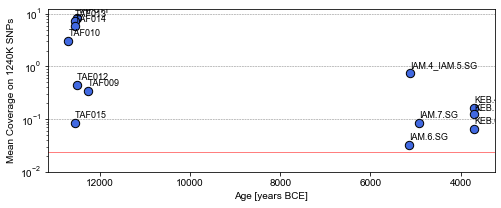

In [49]:
plot_timeline(df_mor, savepath="", xlim=[])

### Do the Figure plot for North African Time Transect

In [18]:
df_nafr = pd.read_csv("./data/plot_nafr.v51.1.tsv", sep="\t")
df1 = df[["iid", "age", "avg_cov_snp", "n_cov_snp", "pop", "loc"]]

df_plot = pd.merge(df1, df_nafr[["iid", "color", "symbol"]], on="iid")

Saved to ./figures/nafr/coverage.v51.pdf


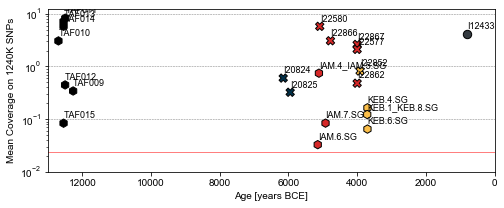

In [23]:
plot_timeline(df_plot, xlim=[0,13000],
              c=df_plot["color"], marker=df_plot["symbol"].values,
              savepath="./figures/nafr/coverage.v51.pdf")

### Plot the Legend

In [24]:
def plot_legend(label, c, marker, figsize = (3,2), s=60, lw=0.4, savepath=""):
    """Plot Legend of the Scatter plot only"""
    fig = plt.figure(figsize=figsize)
    ax = plt.gca()

    # Create the figure
    handles = []
    for i in range(len(label)):
        select = ax.scatter([], [], c=c[i], marker=marker[i],
                            s=s, lw=lw, label=label[i], ec="k")
        handles += [select]
    ax.legend(handles=handles, loc="center")
    ax.axis("off")
    
    ### Save
    if len(savepath)>0:
        plt.savefig(savepath, pad_inches = 0,  
                    bbox_inches = 'tight', dpi=600) #pad_inches = 0, bbox_inches = 'tight'
        print(f"Saved to {savepath}")
    plt.show()

In [53]:
df_leg = df_plot[["symbol","loc", "color"]].value_counts().reset_index().sort_values(by=["color"])
df_leg = df_leg.reset_index(drop=True)

df_leg1 = df_leg.iloc[[0,2,5,1],:].copy().reset_index(drop=True)
df_leg2 = df_leg.iloc[[6,4,3],:].copy().reset_index(drop=True)

Saved to ./figures/nafr/legend.v51.pdf


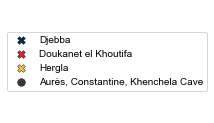

In [54]:
plot_legend(label=df_leg1["loc"], c=df_leg1["color"], marker=df_leg1["symbol"], 
            figsize=(3, 2), s=60, lw=0.4, savepath='./figures/nafr/legend.v51.pdf')

Saved to ./figures/nafr/legend.v51b.pdf


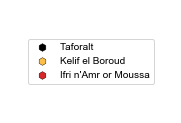

In [56]:
plot_legend(label=df_leg2["loc"], c=df_leg2["color"], marker=df_leg2["symbol"], 
            figsize=(3, 2), s=60, lw=0.4, savepath='./figures/nafr/legend.v51b.pdf')

# Area 51

In [50]:
df_leg

,symbol,loc,color,0
0,X,Djebba,#003049,2
1,o,"Aurès, Constantine, Khenchela Cave",#343a40,1
2,X,Doukanet el Khoutifa,#d62828,5
3,h,Ifri n'Amr or Moussa,#d62828,3
4,h,Kelif el Boroud,#fcbf49,3
5,X,Hergla,#fcbf49,1
6,h,Taforalt,black,7


In [42]:
df_leg

,symbol,loc,color,0
0,X,Djebba,#003049,2
1,o,"Aurès, Constantine, Khenchela Cave",#343a40,1
2,X,Doukanet el Khoutifa,#d62828,5
3,h,Ifri n'Amr or Moussa,#d62828,3
4,h,Kelif el Boroud,#fcbf49,3
5,X,Hergla,#fcbf49,1
6,h,Taforalt,black,7
